## **Paper:** Multi-objective Parameter Tuning with Dynamic Compositional Surrogate Models

In [1]:
import glob
import sys
sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import numpy as np
import pygmo as pg
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("talk")


from plotly import graph_objs as go
import plotly.express as px

from src.composite import ModelsUnion

def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)
def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

### Colect results
It should be noted that in the tables the `hypervolume` value is expressed in accordance with the **currently** evaluated samples. This means that to compare *multiple* optimization experiments, we need to calculate a **common reference point** and recalculate all hypervolume values.

In [9]:
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- TutorM
b1_df = get_data('./data/tutorm/paper/bench_1/WFG12_10_paper_tutor_loop.*.pkl')
b2_df = get_data('./data/tutorm/paper/bench_2/WFG12_10_paper_tutor_loop.*.pkl')
b3_df = get_data('./data/tutorm/paper/bench_3/WFG12_10_paper_tutor_loop.*.pkl')
b4_df = get_data('./data/tutorm/default_tutor/*/WFG12_10_default_tutor_loop.*.pkl')

# --- Fix model
# [1] lathin hypercube sampling (lhs)
# fix_model = get_data('./data/tutorm/paper/ndf_model_lhs_100_wfg1/WFG12_10_paper_tutor_loop.*.pkl')
# fix_model['model name'] = fix_model['model name'].astype(str)
# == lhs end

# [2] sobol sampling
# ===================== Etalon
keys = get_data('./data/tutorm/paper/solo_model_WFG1/lhs_init100/WFG12_10_paper_tutor_loop.*.pkl')[['params hash', 'model name']]
keys['params hash'] = keys['params hash'].astype(str)
keys['model name'] = keys['model name'].astype(str)
keys.drop_duplicates(inplace=True, ignore_index=True)

target = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/dropped_name/WFG12_10_paper_tutor_loop.*.pkl')
target['params hash'] = target['params hash'].astype(str)
target.drop('model name', axis=1, inplace=True)

fix_model = pd.merge(target, keys, how='left', on='params hash')
df_svr = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/WFG12_10_paper_solo_loop.*.pkl')
df_svr['model name'] = df_svr['model name'].astype(str)
fix_model = pd.concat([fix_model,df_svr])
fix_model = fix_model[fix_model['model name']!="nan"]
# == sobol end


# --- NSGA2
nsga2_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals<=1000')
nsga2_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# baseline for reference point
baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)

# --- Hypermapper
mapper_path = './data/hypermapper/all_5x/WFG1_*_output_samples.csv'
mapper_df = pd.concat([pd.read_csv(i_path) for i_path in glob.glob(mapper_path)])

# select 5 experiments (available 10)
selection = b4_df['tutor_id'].unique()[:5]
b4_df = b4_df[b4_df['tutor_id'].isin(selection)]

# --- approach columns for plots
b1_df['approach'] = 'TutorM: ndf init:100'
b2_df['approach'] = 'TutorM: stack init:100'
b3_df['approach'] = 'TutorM: stack+val init:100'
b4_df['approach'] = 'TutorM: stack+val init:0'
nsga2_df['approach'] = 'nsga2'
mapper_df['approach'] = 'Hypermapper'
fix_model['approach'] = fix_model['model name']


# --- Common reference points for all experiments (benchmarks 1, 2, 3, 4)
tutorm_objectives = np.concatenate([np.concatenate(df.pop_ndf_y.values) for df in [b1_df, b2_df, b3_df, b4_df, fix_model]])
all_objectives = np.concatenate([tutorm_objectives, nsga2_df[['f1', 'f2']].values, baseline_df[['f1', 'f2']].values, mapper_df[['f1', 'f2']].values])
ref_point = np.amax(all_objectives, axis=0).tolist()

# --- Update Hypervolume
def upd_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row['pop_ndf_y']).compute(ref_point) 
    row.hypervolume = hypervolume
    return row

def upd_hypervolume_moea(focus_df, ref_point):   
    df_copy = focus_df.copy()      
    obj = df_copy[['f1', 'f2']].values
    hypervolume = []
    for i in range(len(df_copy)):
        if i < 2:
            hypervolume.append(0)   
        else:
            hypervolume.append(pg.hypervolume(obj[:i+1]
                                         ).compute(ref_point))         
    df_copy['hypervolume'] = hypervolume  
    return df_copy

b1_df = b1_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b2_df = b2_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b3_df = b3_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b4_df = b4_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
fix_model = fix_model.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)


nsga2_df = upd_hypervolume_moea(nsga2_df, ref_point)
mapper_df = upd_hypervolume_moea(mapper_df, ref_point)
mapper_df = mapper_df.reset_index().rename(columns={"index": "i_fevals"})
mapper_df.i_fevals = mapper_df.i_fevals + 1
mapper_df = mapper_df.query('i_fevals>=100')

# --- Sort values for proper plotting
b1_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b2_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b3_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b4_df.sort_values(by='i_fevals', ascending=False, inplace=True)
fix_model.sort_values(by='i_fevals', ascending=False, inplace=True)
mapper_df.sort_values(by='i_fevals', ascending=False, inplace=True)

### Rescale Hypervolume

- **max** is hypervolume from NSGA2 with `50 000` functions evalutions
- **min** is minimal hypervolume from non-dominated solutions in 10 random points

![eq](https://a8h2w5y7.rocketcdn.me/wp-content/uploads/2015/11/normalize-data.png)

In [10]:
# ---- Baseline [Max]
# baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
# baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
max_hv = baseline_df.groupby(['group_id']).apply(upd_hypervolume_moea, ref_point).mean().hypervolume

# ---- Min
udp = pg.wfg(prob_id=1, dim_dvs=2, dim_obj=2, dim_k=1)  # == WFG
pro = pg.problem(udp)
pop = pg.population(pro, size=10, seed=42)
min_hv = pg.hypervolume(make_nd_pop(pro, pop.get_x(), pop.get_f()).get_f()).compute(ref_point)

for temp_df in [b1_df, b2_df, b3_df, b4_df, fix_model, nsga2_df, mapper_df]:
    temp_df['hypervolume'] = ((temp_df['hypervolume']-min_hv)/(max_hv-min_hv))

## Static single and compositional models
 \+ NSGA2 and Hypermapper 2.0

In [11]:
plt.figure(figsize=(24, 12))
sns.lineplot(x="i_fevals", y="hypervolume", hue="approach", markers=True,
             palette="deep",
             data=pd.concat([fix_model, nsga2_df, mapper_df]))

___
## Portfolio with single and compositional models
 \+ NSGA2 and Hypermapper 2.0

In [5]:
plt.figure(figsize=(24, 12))
sns.lineplot(x="i_fevals", y="hypervolume", hue="approach", markers=True,
             palette="deep",
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df]))

___
## Overall comparison: Portfolio(TutorM) vs Static surrogate

In [6]:
start_plot = px.line(pd.concat([b1_df, b2_df, b3_df, b4_df, fix_model]).groupby(['approach', 'i_fevals']).mean().reset_index(),  
            x="i_fevals", 
            y="hypervolume",
                     color='approach',
#             hover_name="i_time", 
#             color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(151,255,0)', 'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec'],
            template="presentation+plotly_white",
            line_shape="spline", 
            render_mode="svg")
start_plot

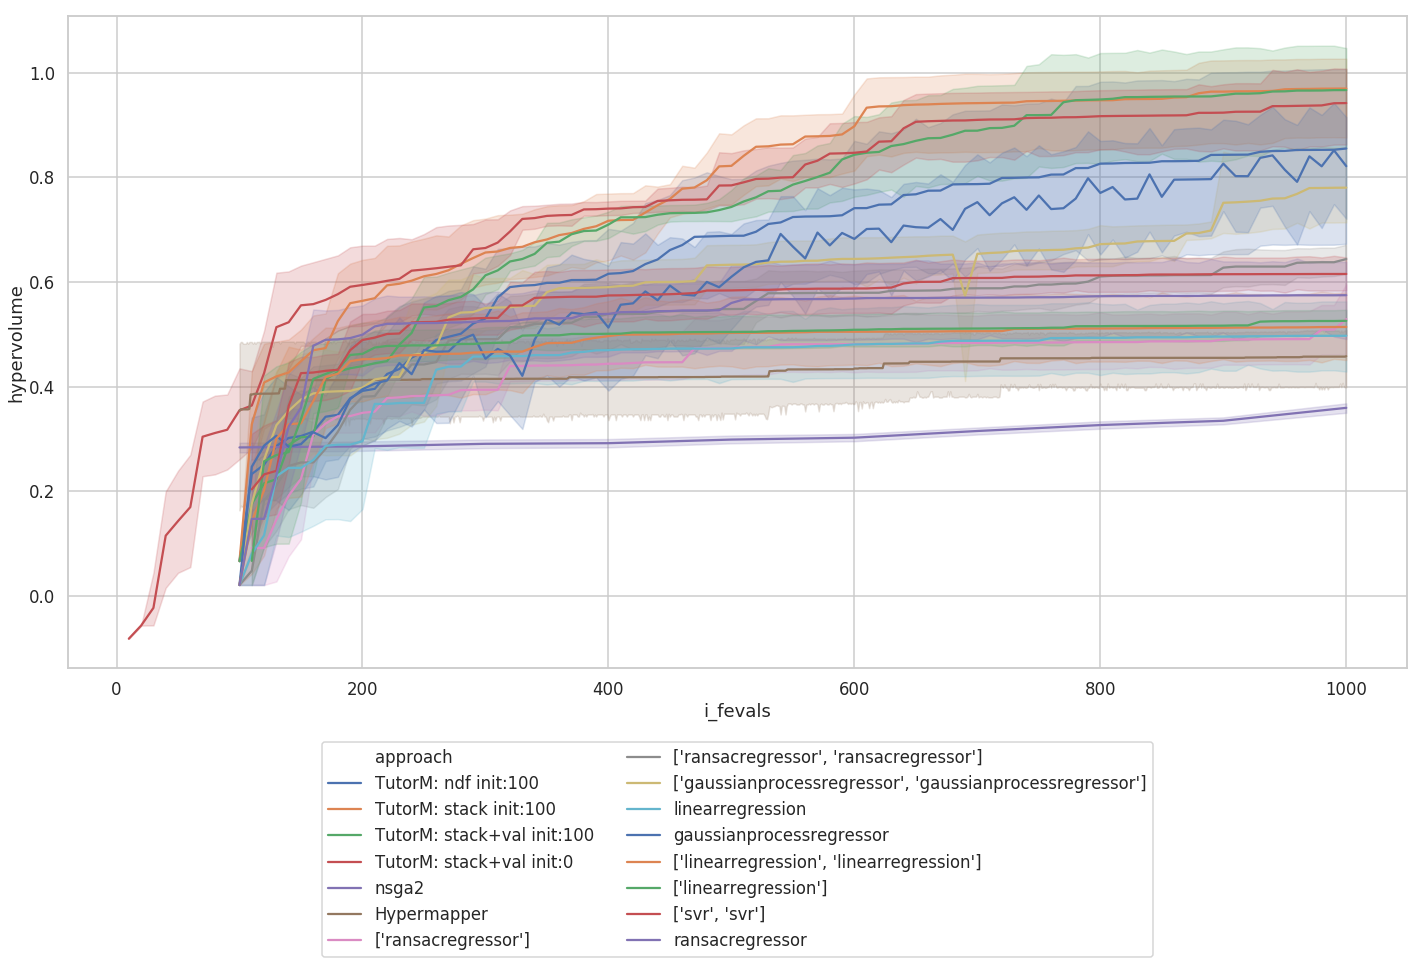

In [7]:
plt.figure(figsize=(24, 12))

p = sns.lineplot(x="i_fevals", y="hypervolume", hue="approach", markers=True,
             palette="deep",
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df, fix_model]))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

## Extra plots

In [29]:
EXP_ORDER = 0 # 0-4

plt.figure(figsize=(24, 12))
summ = []
# --- TutorM
for temp_df in [b1_df, b2_df, b3_df, b4_df]:
    i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
    temp_tutor = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'] )
    temp_tutor['approach'] = i_result.approach
    temp_tutor['group'] = 'tutorm'
    summ.append(temp_tutor)
    
# --- NSGA2    
temp_nsga2 = list(nsga2_df.query('i_fevals==1000').groupby('group_id'))[EXP_ORDER][1]
temp_nsga2 = temp_nsga2[['f1', 'f2', 'approach']]
temp_nsga2['group'] = 'competitor'

summ.append(temp_nsga2)


# --- [Baseline] NSGA2 50k    
temp_base = list(baseline_df.groupby('group_id'))[EXP_ORDER][1]
temp_base = temp_base[['f1', 'f2']]
temp_base['group'] = 'baseline'
temp_base['approach'] = 'NSGA2 50k'
summ.append(temp_base)


# --- Static models
for typle in list(fix_model.query('i_fevals==1000').groupby('model name')):
    i_result = typle[1].iloc[EXP_ORDER]
    temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'] )
    temp_static['approach'] = i_result.approach
    temp_static['group'] = 'static'
    summ.append(temp_static)
    
# --- Hypermapper
all_points = mapper_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(df[['f1','f2']].values)
temp_mapper = all_points.iloc[index_ndf[0]][['f1','f2','approach']]
temp_mapper['group'] = 'competitor'
summ.append(temp_mapper)

sns.lineplot(data=pd.concat(summ), x='f1', y='f2', markers=True, palette="deep", style="group", hue='approach').set_title("Pareto front")    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

In [27]:
pareto_mapper

i_fevals  Timestamp        x2            x1        f2        f1  \
i_fevals                                                                    
284            284     966157  1.400294  5.402729e-04  1.568211  2.363286   
324            324    1169225  1.400294  1.932449e-03  1.455558  2.430427   
411            411    1610196  1.400002  1.708151e+00  0.755395  2.745479   
418            418    1643465  1.400002  1.680900e+00  0.755402  2.744472   
431            431    1715945  1.400002  1.697359e+00  0.755398  2.745082   
...            ...        ...       ...           ...       ...       ...   
985            985    4719705  1.400002  1.703277e+00  0.755396  2.745300   
989            989    4799530  1.399999  8.327875e-01  0.757121  2.699162   
993            993    4823002  1.399999  8.453866e-01  0.756953  2.700089   
999            999    4853443  1.399999  8.524429e-01  0.756862  2.700602   
1000          1000    4868929  1.402598  3.697924e-07  1.828100  2.058781   

             approach  hypervolume  
i_fevals                            
284       Hypermapper     0.511170  
324       Hypermapper     0.512382  
411       Hypermapper     0.512435  
418       Hypermapper     0.512435  
431       Hypermapper     0.512435  
...               ...          ...  
985       Hypermapper     0.512856  
989       Hypermapper     0.510441  
993       Hypermapper     0.510668  
999       Hypermapper     0.510668  
1000      Hypermapper     0.493211  

[65 rows x 8 columns]